Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [2]:
run ../util/setupConsole_su

In [3]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [4]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [5]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [6]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [7]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [8]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [9]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [10]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
    else:
        print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
    else:
        print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping evspsblveg access-cm2
skipping evspsblsoi access-cm2
skipping tran access-esm1-5
skipping evspsblveg access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping evspsblveg awi-cm-1-1-mr
skipping evspsblsoi awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping evspsblveg ec-earth3
skipping evspsblsoi ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping evspsblveg gfdl-cm4
skipping evspsblsoi gfdl-cm4
skipping ef gfdl-esm4
skipping evspsblveg gfdl-esm4
skipping evspsblsoi gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping evspsblveg giss-e2-1-g
skipping evspsblsoi giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping evspsblveg fgoals-g3
skipping evspsblso

In [11]:
# LOAD FUTURE DATA

cmip6_tasmax_grow_max_ssp245 = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max_ssp245 = ds_global_txx
        cmip6_tasmax_grow_mean_ssp245 = ds_global_t50p
    else:
        cmip6_tasmax_grow_max_ssp245 = xr.concat([cmip6_tasmax_grow_max_ssp245, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean_ssp245 = xr.concat([cmip6_tasmax_grow_mean_ssp245, ds_global_t50p], dim='model')

skipping tasmax max awi-cm-1-1-mr
skipping tasmax max bcc-esm1
skipping tasmax max gfdl-cm4
skipping tasmax max gfdl-esm4
skipping tasmax max giss-e2-1-g
skipping tasmax max kace-1-0-g
skipping tasmax max fgoals-g3
skipping tasmax max inm-cm5-0
skipping tasmax max mpi-esm1-2-hr
skipping tasmax max mpi-esm1-2-lr
skipping tasmax max sam0-unicon


In [12]:
cmip6_tasmax_grow_max_trend = xr.Dataset()
cmip6_tasmax_grow_mean_trend = xr.Dataset()
cmip6_ef_grow_trend = xr.Dataset()

ef_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading growing season trends for %s'%model)

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow_trend = ds_global_ef_trend
        else:
            cmip6_ef_grow_trend = xr.concat([cmip6_ef_grow_trend, ds_global_ef_trend], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
    
    ds_global_txx_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_mean_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))

    if m == 0:
        cmip6_tasmax_grow_max_trend = ds_global_txx_trend
        cmip6_tasmax_grow_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_grow_max_trend = xr.concat([cmip6_tasmax_grow_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_grow_mean_trend = xr.concat([cmip6_tasmax_grow_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading growing season trends for access-cm2
loading growing season trends for access-esm1-5
loading growing season trends for awi-cm-1-1-mr
loading growing season trends for bcc-csm2-mr
loading growing season trends for bcc-esm1
loading growing season trends for canesm5
loading growing season trends for ec-earth3
loading growing season trends for gfdl-cm4
skipping ef gfdl-cm4
loading growing season trends for gfdl-esm4
skipping ef gfdl-esm4
loading growing season trends for giss-e2-1-g
loading growing season trends for kace-1-0-g
skipping ef kace-1-0-g
loading growing season trends for fgoals-g3
loading growing season trends for inm-cm5-0
loading growing season trends for ipsl-cm6a-lr
loading growing season trends for miroc6
loading growing season trends for mpi-esm1-2-hr
loading growing season trends for mpi-esm1-2-lr
loading growing season trends for mri-esm2-0
loading growing season trends for noresm2-lm
loading growing season trends for noresm2-mm
loading growing season trends for

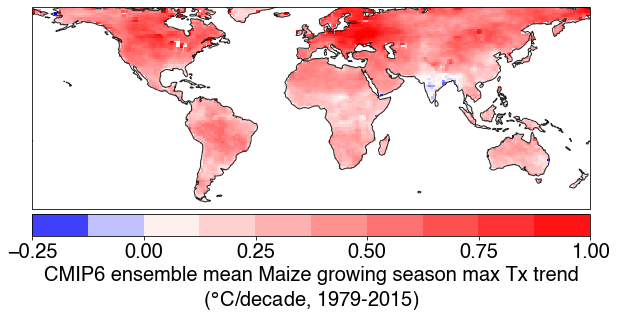

In [203]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
    
v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

disp_lat = cmip6_tasmax_grow_max_trend.lat.values.copy()
disp_lon = cmip6_tasmax_grow_max_trend.lon.values.copy()       
disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.mean(dim='model').values.copy()
# disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season max Tx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

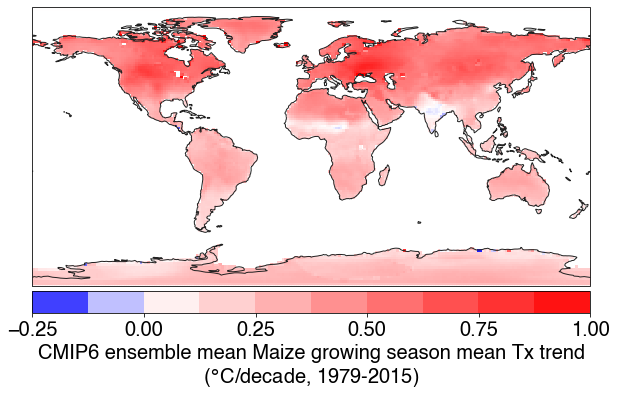

In [204]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(cmip6_tasmax_grow_mean_trend.lon, cmip6_tasmax_grow_mean_trend.lat, cmip6_tasmax_grow_mean_trend.tasmax_grow_mean_trend.mean(dim='model').values, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(cmip6_tasmax_mean_trend.lon, cmip6_tasmax_mean_trend.lat, cmip6_tasmax_mean_trend.tasmax_mean_trend.mean(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))


if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season mean Tx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

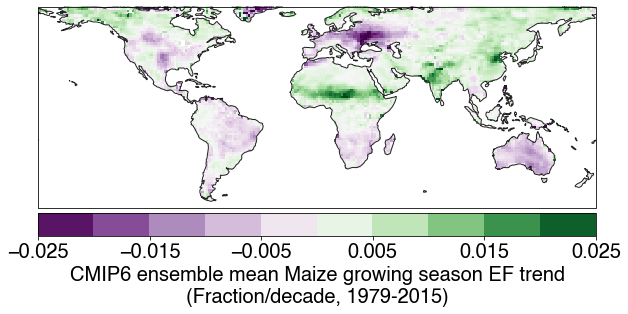

In [205]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
    
v1 = -.025
v2 = .0251
vstep = .005
vlabelstep = .01

disp_lat = cmip6_ef_grow_trend.lat.values.copy()
disp_lon = cmip6_ef_grow_trend.lon.values.copy()       
disp_data = cmip6_ef_grow_trend.grow_ef.mean(dim='model').values.copy()
# disp_data = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean Maize growing season EF trend\n(Fraction/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [206]:
# load era5 growing season temps

era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region))
era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s.nc'%(crop,region))
era5_ef_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s.nc'%(crop,region))
era5_tran_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s.nc'%(crop,region))
era5_evap_from_canopy_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s.nc'%(crop,region))
era5_evap_from_soil_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s.nc'%(crop,region))


In [207]:
%%time

# era5 trends for growing season data
era5_tasmax_grow_max_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)
era5_tasmax_grow_mean_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)    
era5_ef_grow_trend = xr.open_dataset('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
era5_pr_grow_trend = xr.open_dataset('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
era5_tran_grow_trend = xr.open_dataset('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
era5_evap_from_canopy_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
era5_evap_from_soil_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 13.8 ms


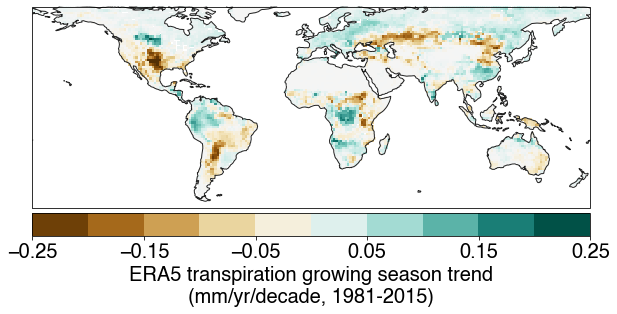

In [208]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -.25
v2 = .251
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.pcolormesh(era5_tasmax_grow_mean_trend.lon, era5_tasmax_grow_mean_trend.lat, era5_tran_grow_trend.trans_grow_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 transpiration growing season trend\n(mm/yr/decade, 1981-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

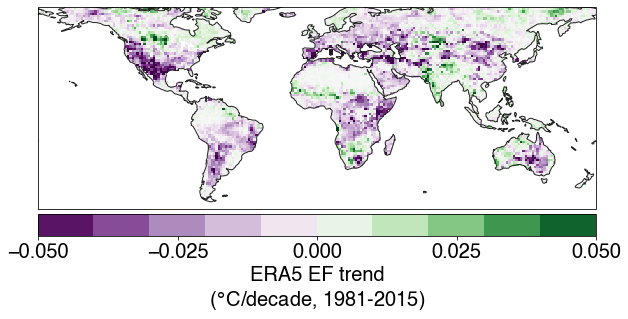

In [209]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])
    
ax.set_extent([-180, -180, 70, -60])
    
v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(era5_ef_grow_trend.lon, era5_ef_grow_trend.lat, era5_ef_grow_trend.ef_grow_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 EF trend\n($\degree$C/decade, 1981-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [210]:
# load pre-calculated bias by year

# monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_mean_bias = np.full([len(cmip6_models), era5_tasmax_grow_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
yearly_ef_grow_bias = np.full([len(cmip6_models), era5_ef_grow_regrid.time.values.shape[0], \
                                   era5_ef_grow_regrid.lat.values.shape[0], \
                                   era5_ef_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
yearly_tran_grow_bias_rel = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_canopy_grow_bias = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_canopy_grow_bias_rel = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_soil_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_soil_grow_bias_rel = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)

    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_mean_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_ef_grow_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_pr_grow_bias.shape[1]):
                yearly_pr_grow_bias_rel[m, y, :, :] = yearly_pr_grow_bias[m, y, :, :]/np.nanmean(era5_pr_grow_regrid.pr_grow_mean, axis=0)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_tran_grow_bias.shape[1]):
                yearly_tran_grow_bias_rel[m, y, :, :] = yearly_tran_grow_bias[m, y, :, :]/-np.nanmean(era5_tran_grow_regrid.trans_grow_mean, axis=0)
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_evap_from_canopy_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_evap_from_canopy_grow_bias.shape[1]):
                yearly_evap_from_canopy_grow_bias_rel[m, y, :, :] = yearly_evap_from_canopy_grow_bias[m, y, :, :]/-np.nanmean(era5_evap_from_canopy_grow_regrid.evap_grow_mean, axis=0)
            
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_evap_from_soil_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_evap_from_soil_grow_bias.shape[1]):
                yearly_evap_from_soil_grow_bias_rel[m, y, :, :] = yearly_evap_from_soil_grow_bias[m, y, :, :]/-np.nanmean(era5_evap_from_soil_grow_regrid.evap_grow_mean, axis=0)
            
# eliminate huge bias grid cells
# yearly_tasmax_grow_max_bias[abs(yearly_tasmax_grow_max_bias)>10]=np.nan

loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


In [211]:
# yearly_tasmax_grow_max_bias[abs(yearly_tasmax_grow_max_bias)>15]=np.nan

In [212]:
# x=yearly_tasmax_grow_max_bias[5,:,:,:].copy()
# x[x<15]=np.nan
# plt.imshow(np.nanmean(x,axis=0))

In [213]:
et_bias = yearly_tran_grow_bias + yearly_evap_from_canopy_grow_bias + yearly_evap_from_soil_grow_bias

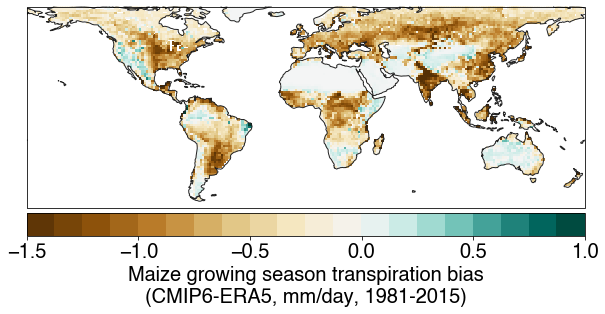

In [214]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season transpiration bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

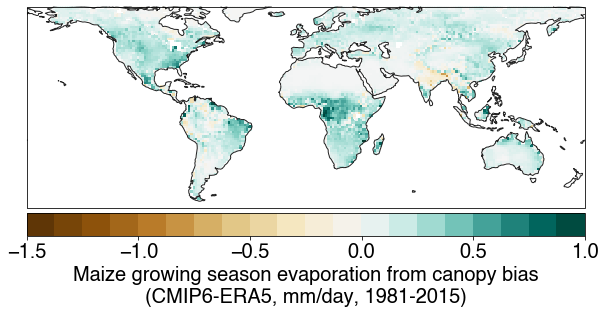

In [215]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season evaporation from canopy bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

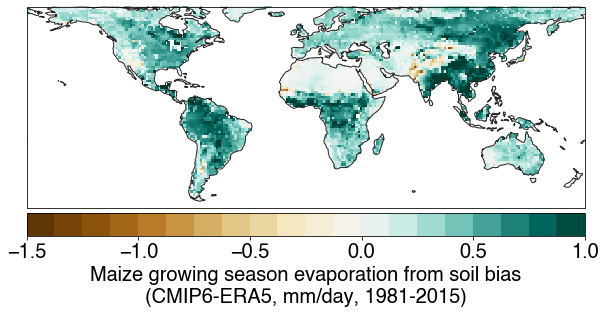

In [216]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season evaporation from soil bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

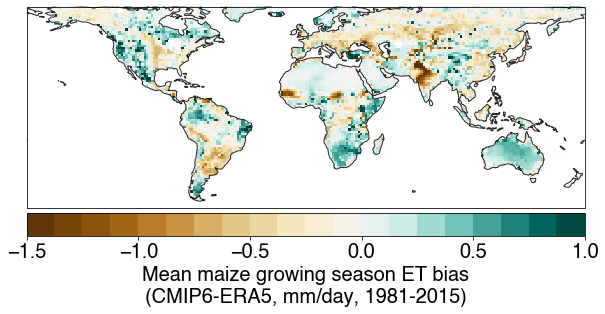

In [217]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(np.nanmean(et_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season ET bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

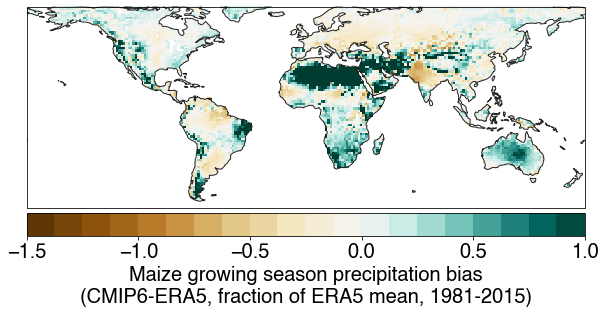

In [218]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(np.nanmean(yearly_pr_grow_bias_rel, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season precipitation bias\n(CMIP6-ERA5, fraction of ERA5 mean, 1981-2015)', fontsize=20)

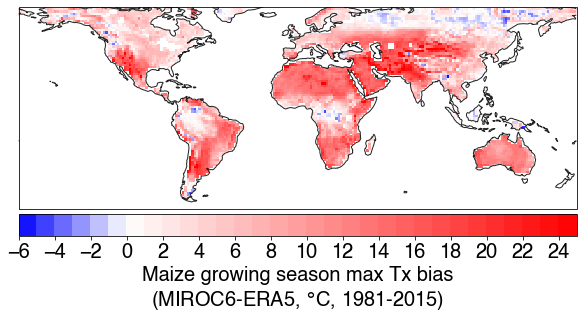

In [219]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -6
v2 = 25.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(yearly_tasmax_grow_max_bias[14,:,:,:], axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season max Tx bias\n(MIROC6-ERA5, $\degree$C, 1981-2015)', fontsize=20)

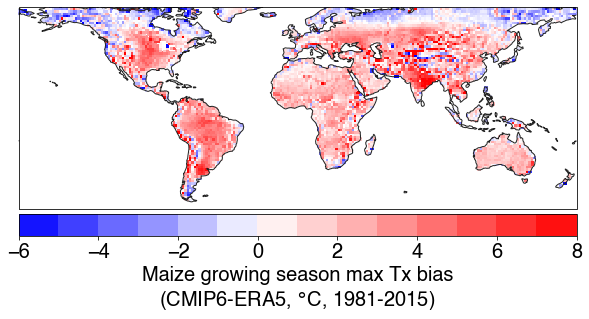

In [220]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -6
v2 = 8.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season max Tx bias\n(CMIP6-ERA5, $\degree$C, 1981-2015)', fontsize=20)

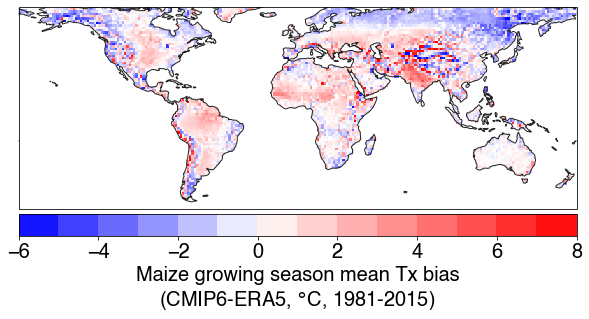

In [221]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -6
v2 = 8.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(np.nanmean(yearly_tasmax_grow_mean_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize growing season mean Tx bias\n(CMIP6-ERA5, $\degree$C, 1981-2015)', fontsize=20)

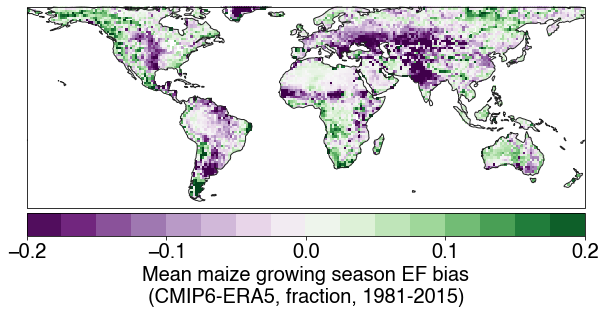

In [222]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -.2
v2 = .21
vstep = .025
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_ef_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season EF bias\n(CMIP6-ERA5, fraction, 1981-2015)', fontsize=20)

In [223]:

yearly_tasmax_grow_max_bias_trend = np.full([len(cmip6_models), yearly_tasmax_grow_max_bias.shape[2], yearly_tasmax_grow_max_bias.shape[3]], np.nan)
yearly_tasmax_grow_max_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_grow_max_bias.shape[2], yearly_tasmax_grow_max_bias.shape[3]], np.nan)

yearly_tasmax_grow_mean_bias_trend = np.full([len(cmip6_models), yearly_tasmax_grow_mean_bias.shape[2], yearly_tasmax_grow_mean_bias.shape[3]], np.nan)
yearly_tasmax_grow_mean_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_grow_mean_bias.shape[2], yearly_tasmax_grow_mean_bias.shape[3]], np.nan)

yearly_ef_grow_bias_trend = np.full([len(cmip6_models), yearly_ef_grow_bias.shape[2], yearly_ef_grow_bias.shape[3]], np.nan)
yearly_ef_grow_bias_trend_sig = np.full([len(cmip6_models), yearly_ef_grow_bias.shape[2], yearly_ef_grow_bias.shape[3]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading precomputed bias trend for %s...'%model)

        
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-bias-trend-%s-%s.dat'%(region, model), 'rb') as f:
        f = pickle.load(f)
        yearly_tasmax_grow_max_bias_trend[m,:,:] = f['yearly_tasmax_grow_max_bias_trend']
        yearly_tasmax_grow_max_bias_trend_sig[m,:,:] = f['yearly_tasmax_grow_max_bias_trend_sig']

        yearly_tasmax_grow_mean_bias_trend[m,:,:] = f['yearly_tasmax_grow_mean_bias_trend']
        yearly_tasmax_grow_mean_bias_trend_sig[m,:,:] = f['yearly_tasmax_grow_mean_bias_trend_sig']
        
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-trend-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-trend-%s-%s.dat'%(region, model), 'rb') as f:
            f = pickle.load(f)
            yearly_ef_grow_bias_trend[m,:,:] = f['yearly_ef_grow_bias_trend']
            yearly_ef_grow_bias_trend_sig[m,:,:] = f['yearly_ef_grow_bias_trend_sig']


loading precomputed bias trend for access-cm2...
loading precomputed bias trend for access-esm1-5...
loading precomputed bias trend for awi-cm-1-1-mr...
loading precomputed bias trend for bcc-csm2-mr...
loading precomputed bias trend for bcc-esm1...
loading precomputed bias trend for canesm5...
loading precomputed bias trend for ec-earth3...
loading precomputed bias trend for gfdl-cm4...
loading precomputed bias trend for gfdl-esm4...
loading precomputed bias trend for giss-e2-1-g...
loading precomputed bias trend for kace-1-0-g...
loading precomputed bias trend for fgoals-g3...
loading precomputed bias trend for inm-cm5-0...
loading precomputed bias trend for ipsl-cm6a-lr...
loading precomputed bias trend for miroc6...
loading precomputed bias trend for mpi-esm1-2-hr...
loading precomputed bias trend for mpi-esm1-2-lr...
loading precomputed bias trend for mri-esm2-0...
loading precomputed bias trend for noresm2-lm...
loading precomputed bias trend for noresm2-mm...
loading precomputed

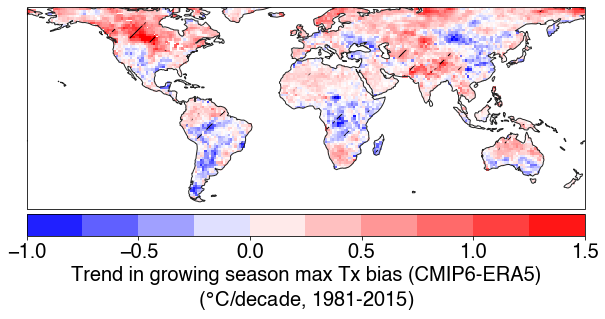

In [224]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(yearly_tasmax_grow_max_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
             np.nanmedian(yearly_tasmax_grow_max_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in growing season max Tx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

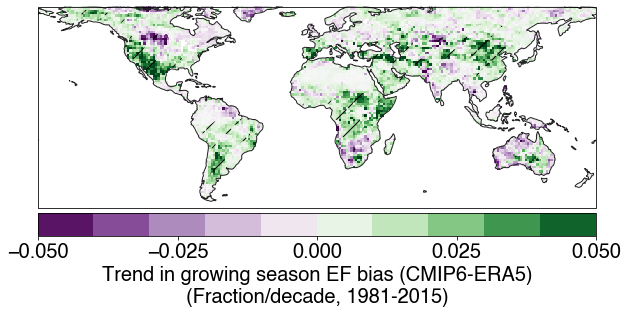

In [225]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
                 np.nanmean(yearly_ef_grow_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, \
             np.nanmedian(yearly_ef_grow_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in growing season EF bias (CMIP6-ERA5)\n(Fraction/decade, 1981-2015)', fontsize=20)

In [226]:
# load cropped area data
print('loading regridded ha')
with open('cropped_area/maize_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    maize_ha_regrid_15 = pickle.load(f)
with open('cropped_area/soy_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    soy_ha_regrid_15 = pickle.load(f)
with open('cropped_area/wheat_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    wheat_ha_regrid_15 = pickle.load(f)
with open('cropped_area/rice_ha_regrid_%d_%d.dat'%(regridMesh['lat'].size, regridMesh['lon'].size), 'rb') as f:
    rice_ha_regrid_15 = pickle.load(f)


loading regridded ha


In [227]:
# crop4_area_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)
crop4_area_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)
crop4_area_chg_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)

for xlat in range(crop4_area_regrid_15.shape[0]):
    for ylon in range(crop4_area_regrid_15.shape[1]):
        
#         tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon], wheat_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
#         tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon], wheat_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
#         tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
#         tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
        tmp1 = maize_ha_regrid_15[0, xlat, ylon]
        tmp2 = maize_ha_regrid_15[-1, xlat, ylon]
        tmp_all = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon], wheat_ha_regrid_15[-1, xlat, ylon]])
        
        tmp_chg = tmp2 - tmp1
        
        if tmp2 > 0:
            crop4_all_area_regrid_15[xlat, ylon] = tmp2
            crop4_area_chg_regrid_15[xlat, ylon] = tmp_chg
        
        crop4_area_regrid_15[xlat, ylon] = tmp_all
            


In [228]:
# crop_ha_regrid_15_1d = np.reshape(crop_ha_regrid_15, [crop_ha_regrid_15.size,1])
# crop_all_ha_regrid_15_1d = np.reshape(crop_all_ha_regrid_15, [crop_all_ha_regrid_15.size,1])
# crop_ha_chg_regrid_15_1d = np.reshape(crop_ha_chg_regrid_15, [crop_ha_chg_regrid_15.size,1])

In [229]:
crop4_area_regrid_15[crop4_area_regrid_15==0] = np.nan

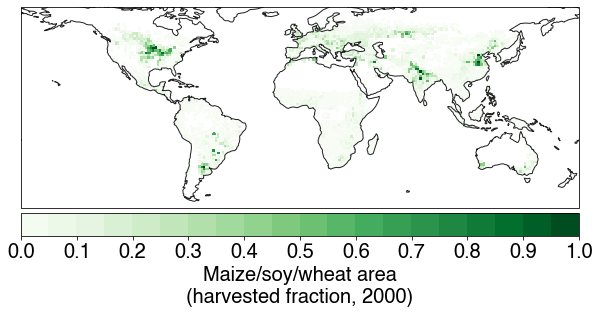

In [230]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop4_area_regrid_15, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize/soy/wheat area\n(harvested fraction, 2000)', fontsize=20)

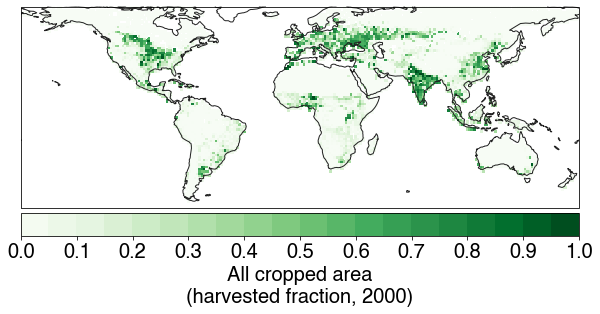

In [231]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop_all_area_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('All cropped area\n(harvested fraction, 2000)', fontsize=20)

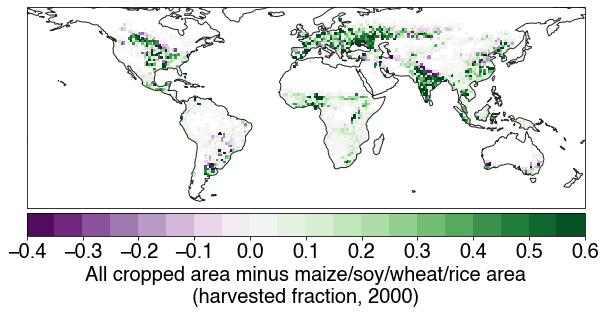

In [232]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = -.40
v2 = .61
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop_all_area_regrid-crop4_area_regrid_15, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('All cropped area minus maize/soy/wheat/rice area\n(harvested fraction, 2000)', fontsize=20)

In [233]:
crop4_area_regrid_1d = np.reshape(crop4_area_regrid_15, [crop4_area_regrid_15.size,1])
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [234]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100

CPU times: user 0 ns, sys: 1.75 ms, total: 1.75 ms
Wall time: 34.3 ms


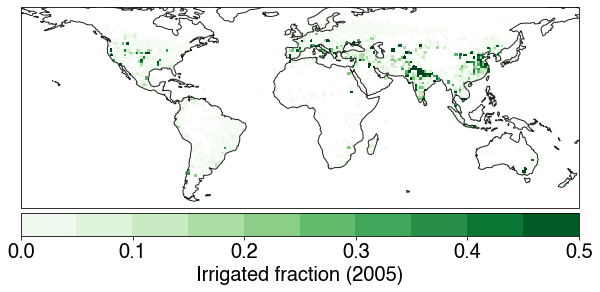

In [235]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], irrigation_data_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Irrigated fraction (2005)', fontsize=20)

In [236]:
cmip6_ha_bias = np.full([len(cmip6_models), cmip6_cropFrac_grow.lat.size, cmip6_cropFrac_grow.lon.size], np.nan)

cmip6_cropFrac_grow_mean = cmip6_cropFrac_grow.grow_cropFrac.mean(dim='time').values

m_rel = 0
for m in range(len(cmip6_models)):
    if cmip6_models[m] in cmip6_cropFrac_grow.model.values:
        print('processing model %s'%cmip6_cropFrac_grow.model[m_rel])
        for xlat in range(cmip6_ha_bias.shape[1]):
            for ylon in range(cmip6_ha_bias.shape[2]):
                cmip6_ha_bias[m_rel, xlat, ylon] = cmip6_cropFrac_grow_mean[m_rel, xlat, ylon]-crop_all_area_regrid[xlat, ylon]*100
        m_rel += 1

processing model <xarray.DataArray 'model' ()>
array('access-cm2', dtype='<U10')
Coordinates:
    model    <U10 'access-cm2'
processing model <xarray.DataArray 'model' ()>
array('access-esm1-5', dtype='<U13')
Coordinates:
    model    <U13 'access-esm1-5'
processing model <xarray.DataArray 'model' ()>
array('canesm5', dtype='<U7')
Coordinates:
    model    <U7 'canesm5'
processing model <xarray.DataArray 'model' ()>
array('gfdl-cm4', dtype='<U8')
Coordinates:
    model    <U8 'gfdl-cm4'
processing model <xarray.DataArray 'model' ()>
array('gfdl-esm4', dtype='<U9')
Coordinates:
    model    <U9 'gfdl-esm4'
processing model <xarray.DataArray 'model' ()>
array('inm-cm5-0', dtype='<U9')
Coordinates:
    model    <U9 'inm-cm5-0'
processing model <xarray.DataArray 'model' ()>
array('ipsl-cm6a-lr', dtype='<U12')
Coordinates:
    model    <U12 'ipsl-cm6a-lr'
processing model <xarray.DataArray 'model' ()>
array('mpi-esm1-2-hr', dtype='<U13')
Coordinates:
    model    <U13 'mpi-esm1-2-hr'
proces

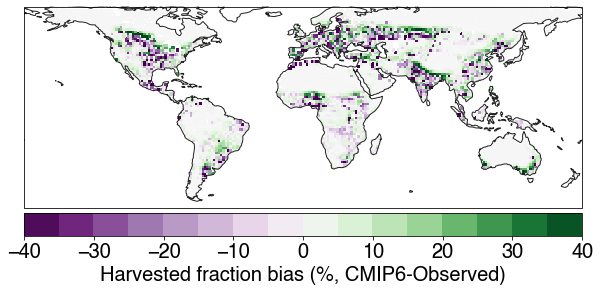

In [237]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

    
ax.set_extent([-180, -180, 70, -60])
    
v1 = -40
v2 = 40.1
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(era5_tasmax_grow_max_trend.lon, era5_tasmax_grow_max_trend.lat, np.nanmean(cmip6_ha_bias, axis=0), cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Harvested fraction bias (%, CMIP6-Observed)', fontsize=20)

In [238]:
# # load deepak data
# maize_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_maize_%s.nc'%region)
# soy_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_soy_%s.nc'%region)
# wheat_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_wheat_%s.nc'%region)

In [239]:
# maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)
# maize_yield_deepak_mean = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

# soy_yield_deepak_trend = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)
# soy_yield_deepak_mean = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)

# wheat_yield_deepak_trend = np.full([wheat_yield_deepak_ds.lat.values.size, wheat_yield_deepak_ds.lon.values.size], np.nan)
# wheat_yield_deepak_mean = np.full([wheat_yield_deepak_ds.lat.values.size, wheat_yield_deepak_ds.lon.values.size], np.nan)

# for xlat in range(maize_yield_deepak_trend.shape[0]):
#     for ylon in range(maize_yield_deepak_trend.shape[1]):
        
#         maize_yield_deepak_mean[xlat, ylon] = np.nanmean(maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon], axis=0)
#         soy_yield_deepak_mean[xlat, ylon] = np.nanmean(soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon], axis=0)
        
#         curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
#         nn = np.where((~np.isnan(curY)))[0]
#         if len(nn) > 20:
#             X = sm.add_constant(range(len(nn)))
#             mdl = sm.OLS(curY[nn], X).fit()
#             maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]
            
#         curY = soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon]
#         nn = np.where((~np.isnan(curY)))[0]
#         if len(nn) > 20:
#             X = sm.add_constant(range(len(nn)))
#             mdl = sm.OLS(curY[nn], X).fit()
#             soy_yield_deepak_trend[xlat, ylon] = mdl.params[1]
            
#         curY = wheat_yield_deepak_ds.wheat_yield.values[:, xlat, ylon]
#         nn = np.where((~np.isnan(curY)))[0]
#         if len(nn) > 20:
#             X = sm.add_constant(range(len(nn)))
#             mdl = sm.OLS(curY[nn], X).fit()
#             wheat_yield_deepak_trend[xlat, ylon] = mdl.params[1]

# maize_yield_deepak_trend_1d = np.reshape(maize_yield_deepak_trend, [maize_yield_deepak_trend.size, 1])
# maize_yield_deepak_mean_1d = np.reshape(maize_yield_deepak_mean, [maize_yield_deepak_mean.size, 1])

# soy_yield_deepak_trend_1d = np.reshape(soy_yield_deepak_trend, [soy_yield_deepak_trend.size, 1])
# soy_yield_deepak_mean_1d = np.reshape(soy_yield_deepak_mean, [soy_yield_deepak_mean.size, 1])

# wheat_yield_deepak_trend_1d = np.reshape(wheat_yield_deepak_trend, [wheat_yield_deepak_trend.size, 1])
# wheat_yield_deepak_mean_1d = np.reshape(wheat_yield_deepak_mean, [wheat_yield_deepak_mean.size, 1])

# prod_trend = maize_yield_deepak_trend*maize_ha_regrid_15[-1,:,:] #+ soy_yield_deepak_trend*soy_ha_regrid_15[-1,:,:] + wheat_yield_deepak_trend*wheat_ha_regrid_15[-1,:,:]
# prod_trend_1d = np.reshape(prod_trend, [prod_trend.size, 1])

# prod_mean = maize_yield_deepak_mean*maize_ha_regrid_15[-1,:,:] #+ soy_yield_deepak_trend*soy_ha_regrid_15[-1,:,:] + wheat_yield_deepak_trend*wheat_ha_regrid_15[-1,:,:]
# prod_mean_1d = np.reshape(prod_mean, [prod_mean.size, 1])

In [240]:
# cmip6_era5_tasmax_grow_max_trend_bias_mean = np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias, axis=0)
# yearly_tasmax_grow_max_bias_trend_mean = np.nanmean(yearly_tasmax_grow_max_bias_trend, axis=0)
yearly_tasmax_grow_max_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=0), axis=0)
yearly_tasmax_grow_mean_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_grow_mean_bias, axis=0), axis=0)
yearly_pr_grow_bias_rel_mean = np.nanmean(np.nanmean(yearly_pr_grow_bias_rel, axis=0), axis=0)

# cmip6_era5_ef_grow_trend_bias_mean = np.nanmean(cmip6_era5_ef_grow_trend_bias, axis=0)
yearly_ef_grow_bias_mean = np.nanmean(np.nanmean(yearly_ef_grow_bias, axis=0), axis=0)
yearly_tran_grow_bias_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0)
yearly_tran_grow_rel_bias_mean = np.nanmean(np.nanmean(yearly_tran_grow_bias_rel, axis=1), axis=0)
yearly_et_grow_bias_mean = np.nanmean(np.nanmean(et_bias, axis=1), axis=0)
yearly_evap_from_canopy_grow_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1), axis=0)
yearly_evap_from_canopy_grow_rel_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_rel, axis=1), axis=0)
yearly_evap_from_soil_grow_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias, axis=1), axis=0)
yearly_evap_from_soil_grow_rel_bias_mean = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_rel, axis=1), axis=0)

# cmip6_era5_tasmax_grow_max_trend_bias_mean_1d = cmip6_era5_tasmax_grow_max_trend_bias_mean.reshape([cmip6_era5_tasmax_grow_max_trend_bias_mean.size, 1])
# yearly_tasmax_grow_max_bias_trend_mean_1d = yearly_tasmax_grow_max_bias_trend_mean.reshape([yearly_tasmax_grow_max_bias_trend_mean.size, 1])
yearly_tasmax_grow_max_bias_mean_1d = yearly_tasmax_grow_max_bias_mean.reshape([yearly_tasmax_grow_max_bias_mean.size, 1])
yearly_tasmax_grow_mean_bias_mean_1d = yearly_tasmax_grow_mean_bias_mean.reshape([yearly_tasmax_grow_mean_bias_mean.size, 1])

# cmip6_era5_ef_grow_trend_bias_mean_1d = cmip6_era5_ef_grow_trend_bias_mean.reshape([cmip6_era5_ef_grow_trend_bias_mean.size, 1])
yearly_ef_grow_bias_mean_1d = yearly_ef_grow_bias_mean.reshape([yearly_ef_grow_bias_mean.size, 1])
yearly_pr_grow_bias_rel_mean_1d = yearly_pr_grow_bias_rel_mean.reshape([yearly_pr_grow_bias_rel_mean.size, 1])
yearly_tran_grow_bias_mean_1d = yearly_tran_grow_bias_mean.reshape([yearly_tran_grow_bias_mean.size, 1])
yearly_tran_grow_rel_bias_mean_1d = yearly_tran_grow_rel_bias_mean.reshape([yearly_tran_grow_rel_bias_mean.size, 1])
yearly_et_grow_bias_mean_1d = yearly_et_grow_bias_mean.reshape([yearly_et_grow_bias_mean.size, 1])
yearly_evap_from_canopy_grow_bias_mean_1d = yearly_evap_from_canopy_grow_bias_mean.reshape([yearly_evap_from_canopy_grow_bias_mean.size, 1])
yearly_evap_from_canopy_grow_rel_bias_mean_1d = yearly_evap_from_canopy_grow_rel_bias_mean.reshape([yearly_evap_from_canopy_grow_rel_bias_mean.size, 1])
yearly_evap_from_soil_grow_bias_mean_1d = yearly_evap_from_soil_grow_bias_mean.reshape([yearly_evap_from_soil_grow_bias_mean.size, 1])
yearly_evap_from_soil_grow_rel_bias_mean_1d = yearly_evap_from_soil_grow_rel_bias_mean.reshape([yearly_evap_from_soil_grow_rel_bias_mean.size, 1])

tran_bias_time_mean = np.nanmean(yearly_tran_grow_bias, axis=1)
tran_bias_time_mean_2d = tran_bias_time_mean.reshape([tran_bias_time_mean.shape[0], tran_bias_time_mean.shape[1]*tran_bias_time_mean.shape[2]])

evap_canopy_bias_time_mean = np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1)
evap_canopy_bias_time_mean_2d = evap_canopy_bias_time_mean.reshape([evap_canopy_bias_time_mean.shape[0], evap_canopy_bias_time_mean.shape[1]*evap_canopy_bias_time_mean.shape[2]])

evap_soil_bias_time_mean = np.nanmean(yearly_evap_from_soil_grow_bias, axis=1)
evap_soil_bias_time_mean_2d = evap_soil_bias_time_mean.reshape([evap_soil_bias_time_mean.shape[0], evap_soil_bias_time_mean.shape[1]*evap_soil_bias_time_mean.shape[2]])

cmip6_ha_bias_mean = np.nanmean(cmip6_ha_bias, axis=0)
cmip6_ha_bias_mean_1d = cmip6_ha_bias_mean.reshape([cmip6_ha_bias_mean.size,1])
cmip6_ha_bias_mean_1d[cmip6_ha_bias_mean_1d==0] = np.nan

In [241]:
nn = np.where((~np.isnan(cmip6_ha_bias_mean_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)))[0]
X = sm.add_constant(cmip6_ha_bias_mean_1d[nn])
mdl_crop_frac_bias = sm.OLS(yearly_tasmax_grow_max_bias_mean_1d[nn], X).fit()

Text(0, 0.5, 'Maize growing season max Tx bias ($\\degree$C)')

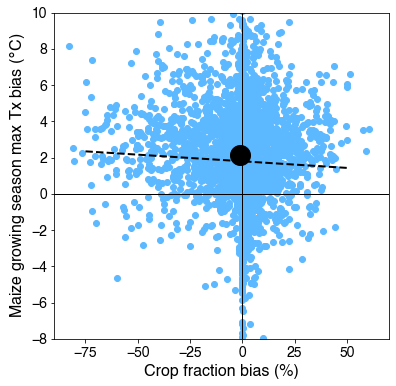

In [242]:
x1 = -75
x2 = 50
plt.figure(figsize=(6,6))
plt.xlim([-90, 70])
plt.ylim([-8, 10])
plt.scatter(cmip6_ha_bias_mean_1d, yearly_tasmax_grow_max_bias_mean_1d, c='#5cb8ff')
plt.plot(np.nanmean(cmip6_ha_bias_mean_1d), np.nanmean(yearly_tasmax_grow_max_bias_mean_1d), 'o', markersize=20, color='k')
plt.plot([x1, x2], [mdl_crop_frac_bias.params[0]+x1*mdl_crop_frac_bias.params[1], mdl_crop_frac_bias.params[0]+x2*mdl_crop_frac_bias.params[1]], '--k', lw=2)
plt.plot([-100,100], [0,0], '-k', lw=1)
plt.plot([0,0], [-8,10], '-k', lw=1)
plt.xlabel('Crop fraction bias (%)')
plt.ylabel('Maize growing season max Tx bias ($\degree$C)')

In [243]:
irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.size,1])

In [244]:
bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]
binned_tran_bias = []
binned_tran_bias_rel = []
binned_tran_bias_per_model = []

binned_evap_canopy_bias = []
binned_evap_canopy_bias_rel = []
binned_evap_canopy_bias_per_model = []

binned_evap_soil_bias = []
binned_evap_soil_bias_rel = []
binned_evap_soil_bias_per_model = []

binned_et_bias = []
for b,bcur in enumerate(bins):
    if b == len(bins)-1:
        ind = np.where((crop_all_area_regrid_1d >= bcur))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur))[0]
    else:
        ind = np.where((crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur) & (crop4_area_regrid_1d < bins[b+1]))[0]
    binned_tran_bias.append(np.nanmean(yearly_tran_grow_bias_mean_1d[ind]))
    binned_tran_bias_rel.append(np.nanmean(yearly_tran_grow_rel_bias_mean_1d[ind]))
    binned_evap_canopy_bias.append(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_1d[ind]))
    binned_evap_canopy_bias_rel.append(np.nanmean(yearly_evap_from_canopy_grow_rel_bias_mean_1d[ind]))
    binned_evap_soil_bias.append(np.nanmean(yearly_evap_from_soil_grow_bias_mean_1d[ind]))
    binned_evap_soil_bias_rel.append(np.nanmean(yearly_evap_from_soil_grow_rel_bias_mean_1d[ind]))
    binned_et_bias.append(np.nanmean(yearly_et_grow_bias_mean_1d[ind]))
    
    for m in range(tran_bias_time_mean_2d.shape[0]):
        if b == 0:
            binned_tran_bias_per_model.append([])
            binned_evap_canopy_bias_per_model.append([])
            binned_evap_soil_bias_per_model.append([])
            
        binned_tran_bias_per_model[m].append(np.nanmean(tran_bias_time_mean_2d[m,ind]))
        binned_evap_canopy_bias_per_model[m].append(np.nanmean(evap_canopy_bias_time_mean_2d[m,ind]))
        binned_evap_soil_bias_per_model[m].append(np.nanmean(evap_soil_bias_time_mean_2d[m,ind]))

Text(0, 0.5, 'Bias (mm/day)')

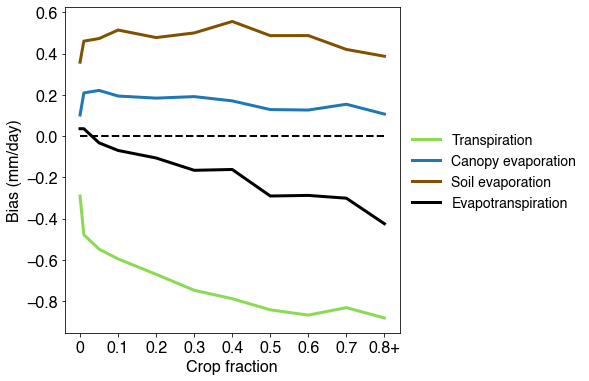

In [245]:
plt.figure(figsize=(6,6))
plt.plot(bins,binned_tran_bias, label='Transpiration', lw=3, c='#8adb53')
plt.plot(bins,binned_evap_canopy_bias, label='Canopy evaporation', lw=3)
plt.plot(bins,binned_evap_soil_bias, label='Soil evaporation', lw=3, c='#805101')
plt.plot(bins,binned_et_bias, label='Evapotranspiration', lw=3, c='k')
plt.plot([0, .8], [0, 0], '--k', lw=2)
plt.legend(prop={'size': 14}, frameon=False, bbox_to_anchor=(1.0, .65))
plt.xticks(np.arange(0, .81, .1), fontsize=16)
plt.gca().set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'])
plt.yticks(fontsize=16)
plt.xlabel('Crop fraction', fontsize=16)
plt.ylabel('Bias (mm/day)', fontsize=16)

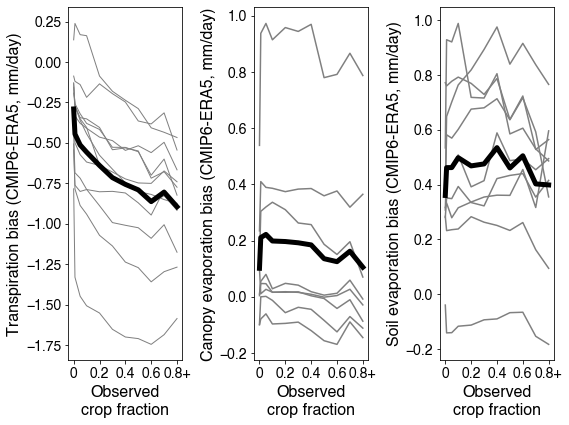

In [246]:

fig, ax = plt.subplots(1,3,figsize=(8,6))

ax[0].plot(bins, np.array(binned_tran_bias_per_model).T, color='gray', lw=1)
ax[0].plot(bins, np.nanmean(np.array(binned_tran_bias_per_model), axis=0), color='k', lw=5)
ax[0].set_xlabel('Observed\ncrop fraction')
ax[0].set_ylabel('Transpiration bias (CMIP6-ERA5, mm/day)')
ax[0].set_xticks(np.arange(0, .81, .2))
ax[0].set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8+'])

ax[1].plot(bins, np.array(binned_evap_canopy_bias_per_model).T, color='gray')
ax[1].plot(bins, np.nanmean(np.array(binned_evap_canopy_bias_per_model), axis=0), color='k', lw=5)
ax[1].set_xlabel('Observed\ncrop fraction')
ax[1].set_ylabel('Canopy evaporation bias (CMIP6-ERA5, mm/day)')
ax[1].set_xticks(np.arange(0, .81, .2))
ax[1].set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8+'])

ax[2].plot(bins, np.array(binned_evap_soil_bias_per_model).T, color='gray')
ax[2].plot(bins, np.nanmean(np.array(binned_evap_soil_bias_per_model), axis=0), color='k', lw=5)
ax[2].set_xlabel('Observed\ncrop fraction')
ax[2].set_ylabel('Soil evaporation bias (CMIP6-ERA5, mm/day)')
ax[2].set_xticks(np.arange(0, .81, .2))
ax[2].set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8+'])
plt.tight_layout()

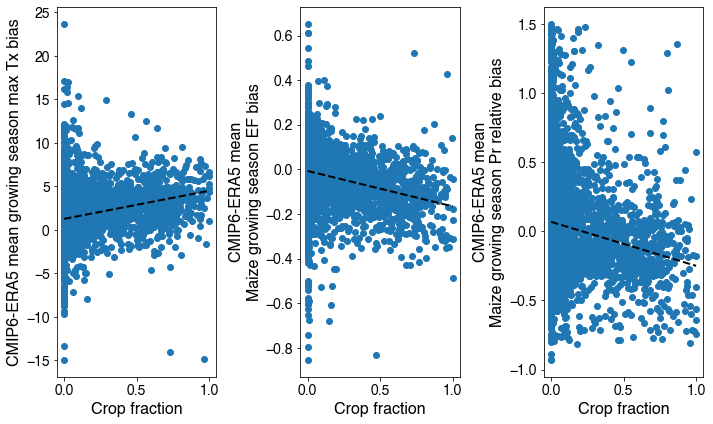

In [247]:

ha_frac_lim_1 = 0
ha_frac_lim_2 = 1

nn_tasmax_grow_max = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_all_area_regrid_1d >= ha_frac_lim_1) & (crop_all_area_regrid_1d <= ha_frac_lim_2))[0]

X = sm.add_constant(crop_all_area_regrid_1d[nn_tasmax_grow_max])
mdl_tasmax_grow_max_bias_mean = sm.RLM(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max], X).fit()

nn_ef_grow = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_ef_grow_bias_mean_1d)) & (crop_all_area_regrid_1d >= ha_frac_lim_1) & (crop_all_area_regrid_1d <= ha_frac_lim_2))[0]
X = sm.add_constant(crop_all_area_regrid_1d[nn_ef_grow])
mdl_ef_grow_mean_bias = sm.RLM(yearly_ef_grow_bias_mean_1d[nn_ef_grow], X).fit()

nn_pr_grow = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_pr_grow_bias_rel_mean_1d)) & (yearly_pr_grow_bias_rel_mean_1d < 1.5) & (crop_all_area_regrid_1d >= ha_frac_lim_1) & (crop_all_area_regrid_1d <= ha_frac_lim_2))[0]
X = sm.add_constant(crop_all_area_regrid_1d[nn_pr_grow])
mdl_pr_grow_mean_bias = sm.RLM(yearly_pr_grow_bias_rel_mean_1d[nn_pr_grow], X).fit()


fig, ax = plt.subplots(1,3,figsize=(10,6))

# x1 = 0
# x2 = 1
# ax[0].scatter(crop_ha_regrid_15_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_trend_mean_1d[nn_tasmax_grow_max])
# ax[0].plot([x1, x2], [mdl_tasmax_grow_max_bias_trend.params[0]+x1*mdl_tasmax_grow_max_bias_trend.params[1], \
#                     mdl_tasmax_grow_max_bias_trend.params[0]+x2*mdl_tasmax_grow_max_bias_trend.params[1]], '--k', lw=2)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_ylabel('CMIP6-ERA5 trend in\nMaize growing season max Tx bias')

x1 = 0
x2 = 1
ax[0].scatter(crop_all_area_regrid_1d[nn_tasmax_grow_max], yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max])
ax[0].plot([x1, x2], [mdl_tasmax_grow_max_bias_mean.params[0]+x1*mdl_tasmax_grow_max_bias_mean.params[1], \
                    mdl_tasmax_grow_max_bias_mean.params[0]+x2*mdl_tasmax_grow_max_bias_mean.params[1]], '--k', lw=2)
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('CMIP6-ERA5 mean growing season max Tx bias')

# x1 = 0
# x2 = 1
# ax[2].scatter(crop_ha_regrid_15_1d[nn_tasmax_grow_max], cmip6_era5_tasmax_grow_max_trend_bias_mean_1d[nn_tasmax_grow_max])
# ax[2].plot([x1, x2], [mdl_tasmax_grow_max_trend_bias.params[0]+x1*mdl_tasmax_grow_max_trend_bias.params[1], \
#                     mdl_tasmax_grow_max_trend_bias.params[0]+x2*mdl_tasmax_grow_max_trend_bias.params[1]], '--k', lw=2)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_ylabel('CMIP6-ERA5 mean\nMaize growing season max Tx trend bias')

x1 = 0
x2 = 1
ax[1].scatter(crop_all_area_regrid_1d[nn_ef_grow], yearly_ef_grow_bias_mean_1d[nn_ef_grow])
ax[1].plot([x1, x2], [mdl_ef_grow_mean_bias.params[0]+x1*mdl_ef_grow_mean_bias.params[1], \
                    mdl_ef_grow_mean_bias.params[0]+x2*mdl_ef_grow_mean_bias.params[1]], '--k', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].set_ylabel('CMIP6-ERA5 mean\nMaize growing season EF bias')

x1 = 0
x2 = 1
ax[2].scatter(crop_all_area_regrid_1d[nn_pr_grow], yearly_pr_grow_bias_rel_mean_1d[nn_pr_grow])
ax[2].plot([x1, x2], [mdl_pr_grow_mean_bias.params[0]+x1*mdl_pr_grow_mean_bias.params[1], \
                    mdl_pr_grow_mean_bias.params[0]+x2*mdl_pr_grow_mean_bias.params[1]], '--k', lw=2)
ax[2].set_xlabel('Crop fraction')
ax[2].set_ylabel('CMIP6-ERA5 mean\nMaize growing season Pr relative bias')


plt.tight_layout()

access-cm2		Mean: 4.74, p = 0.00
access-esm1-5		Mean: 6.43, p = 0.00
awi-cm-1-1-mr		Mean: 1.31, p = 0.00
bcc-csm2-mr		Mean: 5.94, p = 0.00
bcc-esm1		Mean: 4.92, p = 0.00
canesm5		Mean: 1.23, p = 0.00
ec-earth3		Mean: 3.73, p = 0.00
gfdl-cm4		Mean: 3.43, p = 0.00
gfdl-esm4		Mean: 3.19, p = 0.00
giss-e2-1-g		Mean: 0.31, p = 0.20
kace-1-0-g		Mean: 6.43, p = 0.00
fgoals-g3		Mean: 3.46, p = 0.00
inm-cm5-0		Mean: 7.12, p = 0.00
ipsl-cm6a-lr		Mean: 2.55, p = 0.00
miroc6		Mean: 3.41, p = 0.00
mpi-esm1-2-hr		Mean: 0.83, p = 0.00
mpi-esm1-2-lr		Mean: 1.17, p = 0.00
mri-esm2-0		Mean: -0.79, p = 0.00
noresm2-lm		Mean: 4.70, p = 0.00
noresm2-mm		Mean: 4.00, p = 0.00

18 1 1


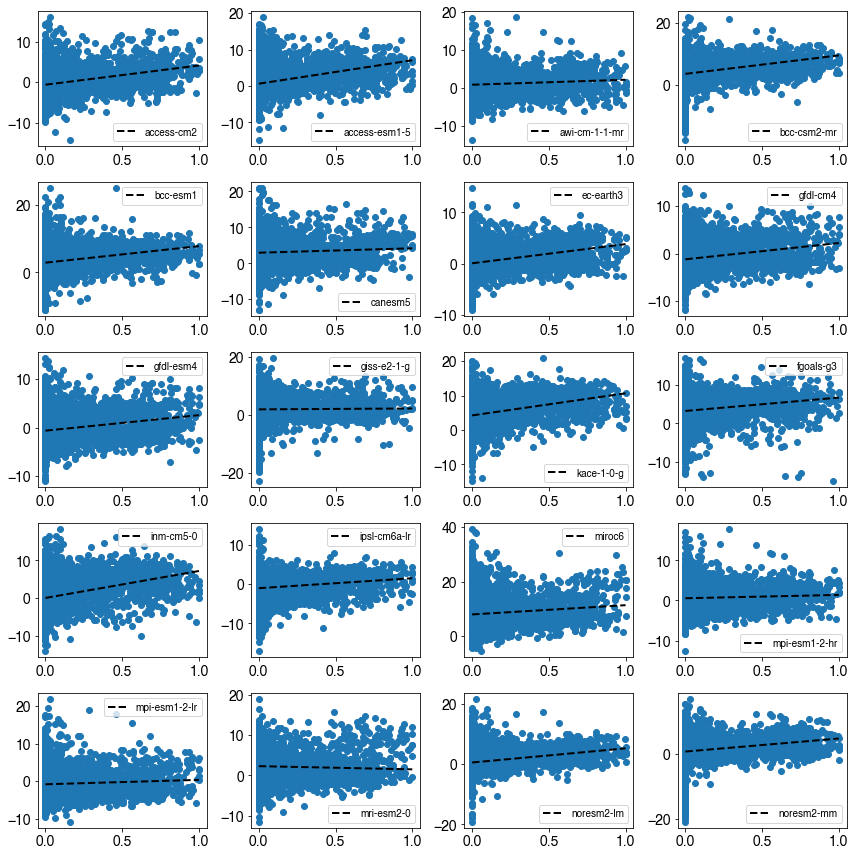

In [248]:
ha_frac_lim_1 = 0
ha_frac_lim_2 = 1

n_pos_sig_mean = 0
n_neg_sig_mean = 0
n_nonsig_mean = 0


fig, ax = plt.subplots(5,4,figsize=(12,12))

m = 0
for x in range(5):
    for y in range(4):
    
        if m >= yearly_tasmax_grow_max_bias.shape[0]:
            break
            
        yearly_tasmax_grow_max_bias_mean_1d = np.reshape(np.nanmean(yearly_tasmax_grow_max_bias[m,:,:,:], axis=0), [yearly_tasmax_grow_max_bias[m,0,:,:].size, 1])
        nn = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_all_area_regrid_1d >= ha_frac_lim_1) & (crop_all_area_regrid_1d <= ha_frac_lim_2))[0]

        X = sm.add_constant(crop_all_area_regrid_1d[nn])
        mdl_mean = sm.RLM(yearly_tasmax_grow_max_bias_mean_1d[nn], X).fit()

        if mdl_mean.params[1] > 0 and mdl_mean.pvalues[1] <= 0.05:
            n_pos_sig_mean += 1
        elif mdl_mean.params[1] < 0 and mdl_mean.pvalues[1] <= 0.05:
            n_neg_sig_mean += 1
        else:
            n_nonsig_mean += 1

        x1 = 0
        x2 = 1
        ax[x,y].scatter(crop_all_area_regrid_1d[nn], yearly_tasmax_grow_max_bias_mean_1d[nn])
        ax[x,y].plot([x1, x2], [mdl_mean.params[0]+x1*mdl_mean.params[1], \
                        mdl_mean.params[0]+x2*mdl_mean.params[1]], '--k', lw=2, label=cmip6_models[m])
        ax[x,y].legend()

        print('%s\t\tMean: %.2f, p = %.2f'%(cmip6_models[m], mdl_mean.params[1], mdl_mean.pvalues[1]))
        m += 1
    
plt.tight_layout()
print()
print(n_pos_sig_mean, n_neg_sig_mean, n_nonsig_mean)


access-cm2		Mean: -0.25, p = 0.00
access-esm1-5		Mean: -0.59, p = 0.00
bcc-esm1		Mean: -0.24, p = 0.00
canesm5		Mean: -0.27, p = 0.00
ec-earth3		Mean: -0.10, p = 0.00
gfdl-esm4		Mean: -0.31, p = 0.00
kace-1-0-g		Mean: -0.36, p = 0.00
fgoals-g3		Mean: -0.31, p = 0.00
inm-cm5-0		Mean: -0.45, p = 0.00
ipsl-cm6a-lr		Mean: -0.15, p = 0.00
miroc6		Mean: -0.31, p = 0.00
mpi-esm1-2-hr		Mean: -0.15, p = 0.00
mpi-esm1-2-lr		Mean: -0.15, p = 0.00
mri-esm2-0		Mean: -0.08, p = 0.00
noresm2-lm		Mean: -0.27, p = 0.00

0 15 0


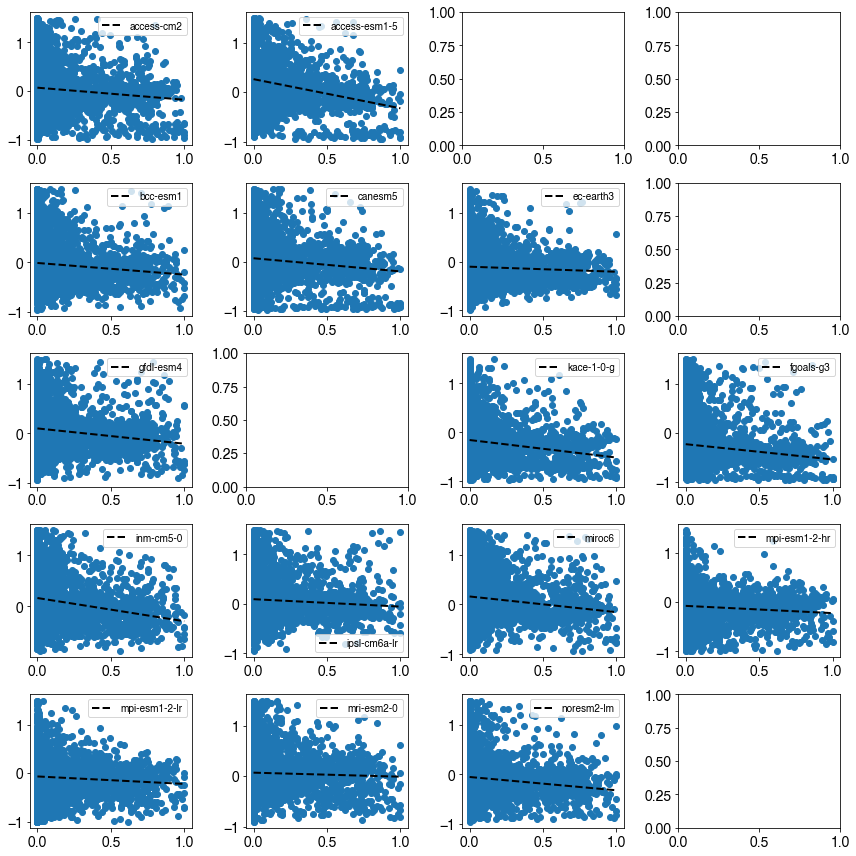

In [249]:
ha_frac_lim_1 = 0
ha_frac_lim_2 = 1

n_pos_sig_mean = 0
n_neg_sig_mean = 0
n_nonsig_mean = 0


fig, ax = plt.subplots(5,4,figsize=(12,12))

m = 0
for x in range(5):
    for y in range(4):
    
        if m >= yearly_tasmax_grow_max_bias.shape[0]:
            break
            
        yearly_pr_grow_bias_rel_cur_model_1d = np.reshape(np.nanmean(yearly_pr_grow_bias_rel[m,:,:,:], axis=0), [yearly_pr_grow_bias_rel[m,0,:,:].size, 1])
        nn = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_pr_grow_bias_rel_cur_model_1d)) & (yearly_pr_grow_bias_rel_cur_model_1d < 1.5) & (crop_all_area_regrid_1d >= ha_frac_lim_1) & (crop_all_area_regrid_1d <= ha_frac_lim_2))[0]

        if len(nn) > 0:
            X = sm.add_constant(crop_all_area_regrid_1d[nn])
            mdl_mean = sm.RLM(yearly_pr_grow_bias_rel_cur_model_1d[nn], X).fit()

            if mdl_mean.params[1] > 0 and mdl_mean.pvalues[1] <= 0.05:
                n_pos_sig_mean += 1
            elif mdl_mean.params[1] < 0 and mdl_mean.pvalues[1] <= 0.05:
                n_neg_sig_mean += 1
            else:
                n_nonsig_mean += 1

            x1 = 0
            x2 = 1
            ax[x,y].scatter(crop_all_area_regrid_1d[nn], yearly_pr_grow_bias_rel_cur_model_1d[nn])
            ax[x,y].plot([x1, x2], [mdl_mean.params[0]+x1*mdl_mean.params[1], \
                            mdl_mean.params[0]+x2*mdl_mean.params[1]], '--k', lw=2, label=cmip6_models[m])
            ax[x,y].legend()

            print('%s\t\tMean: %.2f, p = %.2f'%(cmip6_models[m], mdl_mean.params[1], mdl_mean.pvalues[1]))
        m += 1
    
plt.tight_layout()
print()
print(n_pos_sig_mean, n_neg_sig_mean, n_nonsig_mean)


In [250]:
cmip6_ha_bias_global_grop_1d = cmip6_ha_bias.reshape([cmip6_ha_bias.shape[0], cmip6_ha_bias.shape[1]*cmip6_ha_bias.shape[2]])

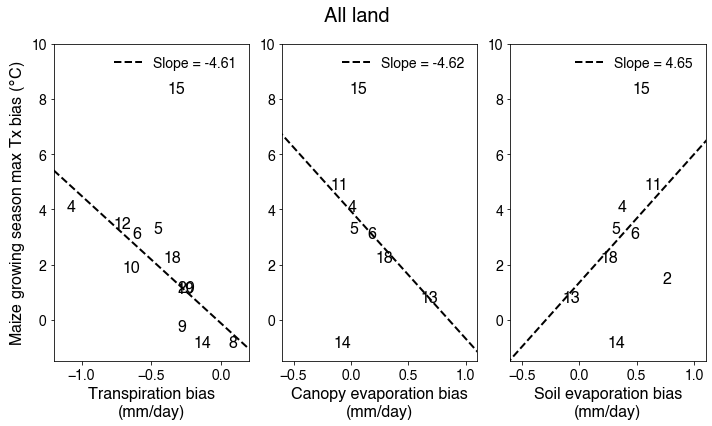

In [251]:
nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                  yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_tran_grow_bias_mean_global_crop_1d))[0]
X = sm.add_constant(yearly_tran_grow_bias_mean_global_crop_1d[nn])
mdl_tran = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()



yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                  yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d))[0]
X = sm.add_constant(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[nn])
mdl_canopy = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()



yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                  yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_1d))[0]
X = sm.add_constant(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[nn])
mdl_soil = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()

mdl_leg = {}

x1 = -1.2
x2 = 0.2
fig, ax = plt.subplots(1,3,figsize=(10,6))

# plt.plot([np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].set_ylim([-1.5, 10])
ax[0].set_xlim([-1.2, .2])
ax[0].plot([x1, x2], [mdl_tran.params[0]+x1*mdl_tran.params[1], \
                    mdl_tran.params[0]+x2*mdl_tran.params[1]], '--k', lw=2, label='Slope = %.2f'%(mdl_tran.params[1]))
for m in range(yearly_tran_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_tran_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        ax[0].text(yearly_tran_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
# ax[0].scatter(yearly_tran_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[0].set_xlabel('Transpiration bias\n(mm/day)')
ax[0].set_ylabel('Maize growing season max Tx bias ($\degree$C)')
ax[0].legend(frameon=False, prop={'size': 14})

x1 = -.7
x2 = 1.2
ax[1].set_ylim([-1.5, 10])
ax[1].set_xlim([-.6, 1.1])
ax[1].plot([x1, x2], [mdl_canopy.params[0]+x1*mdl_canopy.params[1], \
                    mdl_canopy.params[0]+x2*mdl_canopy.params[1]], '--k', lw=2, label='Slope = %.2f'%mdl_canopy.params[1])
for m in range(yearly_tran_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        ax[1].text(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')

# ax[1].scatter(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[1].set_xlabel('Canopy evaporation bias\n(mm/day)')
ax[1].legend(frameon=False, prop={'size': 14})



x1 = -.7
x2 = 1.2
ax[2].set_xlim([-.6, 1.1])
ax[2].set_ylim([-1.5, 10])
ax[2].plot([x1, x2], [mdl_soil.params[0]+x1*mdl_soil.params[1], \
                    mdl_soil.params[0]+x2*mdl_soil.params[1]], '--k', lw=2, label='Slope = %.2f'%mdl_soil.params[1])
for m in range(yearly_evap_from_soil_grow_bias_mean_global_crop_1d.size):
    if not np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[m]) and not np.isnan(tasmax_max_bias_global_crop_1d[m]):
        mdl_leg[m] = cmip6_models[m]
        ax[2].text(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[m], tasmax_max_bias_global_crop_1d[m], '%d'%(m+1), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')

# ax[2].scatter(yearly_evap_from_soil_grow_bias_mean_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, c='k')
ax[2].set_xlabel('Soil evaporation bias\n(mm/day)')
ax[2].legend(frameon=False, prop={'size': 14})
plt.suptitle('All land', fontsize=20)



ax2_leg_label = []
for m in mdl_leg.keys():
    ax2_leg_label.append('%d - %s'%(m, mdl_leg[m]))
# leg2 = ax[2].legend(ax2_leg_label)
# ax[2].add_artist(leg2)
plt.tight_layout()

plt.savefig('evap-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
# yearly_evap_from_canopy_grow_bias

In [252]:
cmip6_models[14]

'miroc6'

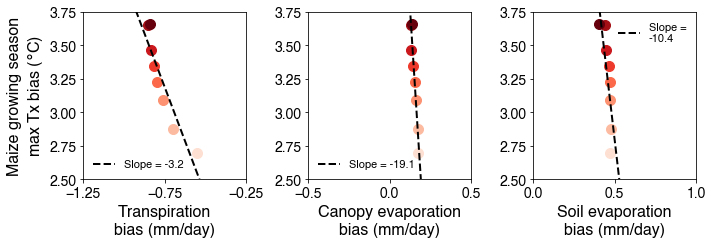

In [253]:
# NOW SHOW BOTTOM PLOTS WITH VARYING CROPLAND

fig, ax = plt.subplots(1,3,figsize=(10,3.5))

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .05, .1, .15, .25, .4]

ax2_leg_lines = []
ax2_leg_label = []

tran_x = np.full([len(lims)], np.nan)
evap_canopy_x = np.full([len(lims)], np.nan)
evap_soil_x = np.full([len(lims)], np.nan)
temp_y = np.full([len(lims)], np.nan)

for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                      yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
    yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                      yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                      yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    ax[0].plot(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    tran_x[i] = np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)
    temp_y[i] = np.nanmean(tasmax_max_bias_global_crop_1d)
    
    ax[1].plot(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_canopy_x[i] = np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d)
    
    p = ax[2].plot(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_soil_x[i] = np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d)
    
    ax2_leg_lines.append(p)
    ax2_leg_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))

X = sm.add_constant(tran_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = -.475
x2 = -1.0

# ax[0].set_xlabel('Mean transpiration\nbias (mm/day)')
ax[0].set_xlim([-1.25,-.25])
ax[0].set_ylim([2.5,3.75])
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope = %.1f'%mdl.params[1])
ax[0].set_ylabel('Maize growing season\nmax Tx bias ($\degree$C)')
ax[0].set_xlabel('Transpiration\nbias (mm/day)')
ax[0].set_xticks([-1.25, -.75, -.25])
ax[0].legend(frameon=False, prop={'size': 11})


X = sm.add_constant(evap_canopy_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = .23
x2 = .1

# ax[1].set_xlabel('Mean canopy evaporation\nbias (mm/day)')
ax[1].set_xlim([-.5,.5])
ax[1].set_ylim([2.5,3.75])
ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope = %.1f'%mdl.params[1])
# ax[1].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[1].set_xlabel('Canopy evaporation\nbias (mm/day)')
ax[1].set_xticks([-.5, 0, .5])
ax[1].legend(frameon=False, prop={'size': 11})
    
    
X = sm.add_constant(evap_soil_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = .35
x2 = .625
# ax[2].set_xlabel('Mean soil evaporation\nbias (mm/day)')
ax[2].set_xlim([0,1])
ax[2].set_ylim([2.5,3.75])
ax[2].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope =\n%.1f'%mdl.params[1])
# ax[2].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[2].set_xlabel('Soil evaporation\nbias (mm/day)')
ax[2].set_xticks([0, .5, 1])
ax[2].legend(frameon=False, prop={'size': 11})

# leg1 = ax[2].legend(p, frameon=False, prop={'size': 11})
# leg2 = ax[2].legend(ax2_leg_label, frameon=False, bbox_to_anchor=(1.0, 1), prop={'size': 13})
# ax[2].add_artist(leg1)

# plt.suptitle('Global cropland (fraction > 0)', fontsize=20)
plt.tight_layout()

plt.savefig('evap-bias-model-avg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

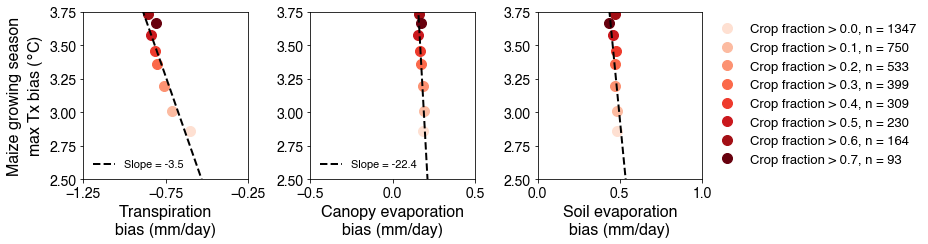

In [254]:
# SAME AS ABOVE BUT WITH NO IRRIGATION

fig, ax = plt.subplots(1,3,figsize=(13,3.5))

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .05, .1, .15, .25, .4]

ax2_leg_lines = []
ax2_leg_label = []

tran_x = np.full([len(lims)], np.nan)
evap_canopy_x = np.full([len(lims)], np.nan)
evap_soil_x = np.full([len(lims)], np.nan)
temp_y = np.full([len(lims)], np.nan)

for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim) & (irrigation_data_regrid_1d < .1))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                      yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
    yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                      yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                      yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    ax[0].plot(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    tran_x[i] = np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d)
    temp_y[i] = np.nanmean(tasmax_max_bias_global_crop_1d)
    
    ax[1].plot(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_canopy_x[i] = np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d)
    
    p = ax[2].plot(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=10, color=cmap(((i+1)/len(lims))))
    evap_soil_x[i] = np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d)
    
    ax2_leg_lines.append(p)
    ax2_leg_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))

X = sm.add_constant(tran_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = -.475
x2 = -1.0

# ax[0].set_xlabel('Mean transpiration\nbias (mm/day)')
ax[0].set_xlim([-1.25,-.25])
ax[0].set_ylim([2.5,3.75])
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope = %.1f'%mdl.params[1])
ax[0].set_ylabel('Maize growing season\nmax Tx bias ($\degree$C)')
ax[0].set_xlabel('Transpiration\nbias (mm/day)')
ax[0].set_xticks([-1.25, -.75, -.25])
ax[0].legend(frameon=False, prop={'size': 11})


X = sm.add_constant(evap_canopy_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = .23
x2 = .1

# ax[1].set_xlabel('Mean canopy evaporation\nbias (mm/day)')
ax[1].set_xlim([-.5,.5])
ax[1].set_ylim([2.5,3.75])
ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope = %.1f'%mdl.params[1])
# ax[1].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[1].set_xlabel('Canopy evaporation\nbias (mm/day)')
ax[1].set_xticks([-.5, 0, .5])
ax[1].legend(frameon=False, prop={'size': 11})
    
    
X = sm.add_constant(evap_soil_x)
mdl = sm.RLM(temp_y, X).fit()
x1 = .35
x2 = .625
# ax[2].set_xlabel('Mean soil evaporation\nbias (mm/day)')
ax[2].set_xlim([0,1])
ax[2].set_ylim([2.5,3.75])
ax[2].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='Slope = %.1f'%mdl.params[1])
# ax[2].set_ylabel('Max growing season\ntasmax bias ($\degree$C)')
ax[2].set_xlabel('Soil evaporation\nbias (mm/day)')
ax[2].set_xticks([0, .5, 1])
ax[2].legend(ax2_leg_label, frameon=False, prop={'size': 13}, bbox_to_anchor=(1.0, 1))

# plt.suptitle('Global cropland (fraction > 0)', fontsize=20)
plt.tight_layout()


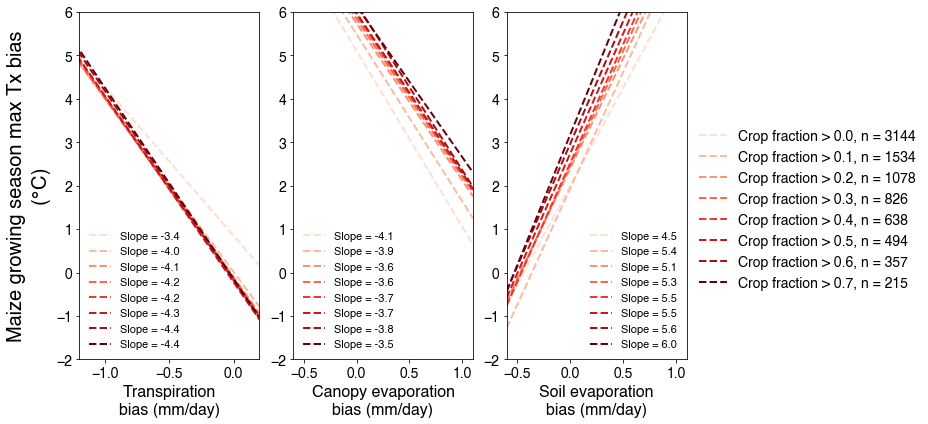

In [255]:
# NOW SHOW BOTTOM PLOTS WITH VARYING CROPLAND

fig, ax = plt.subplots(1,3,figsize=(13,6))

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .1, .2, .3, .4, .5, .6, .7, .8]

ax2_leg_lines = []
ax2_leg1_label = []
ax2_leg2_label = []

for i, lim in enumerate(lims):
    
#      & (irrigation_data_regrid_1d < .01)
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]
    
    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    yearly_tran_grow_bias_mean_global_crop_1d = yearly_tran_grow_bias.reshape([yearly_tran_grow_bias.shape[0], yearly_tran_grow_bias.shape[1], \
                                                                      yearly_tran_grow_bias.shape[2]*yearly_tran_grow_bias.shape[3]])
    yearly_tran_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_tran_grow_bias_mean_global_crop_1d))[0]
    X = sm.add_constant(yearly_tran_grow_bias_mean_global_crop_1d[nn])
    mdl_tran = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()
    
    if i == 0:
        label = 'Slope = %.1f'%(mdl_tran.params[1])
    else:
        label = 'Slope = %.1f'%(mdl_tran.params[1])
    
    x1 = -1.5
    x2 = 0.2
    ax[0].plot([x1, x2], [mdl_tran.params[0]+x1*mdl_tran.params[1], \
                        mdl_tran.params[0]+x2*mdl_tran.params[1]], '--', color=cmap(((i+1)/len(lims))), lw=2, label=label)
    





    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = yearly_evap_from_canopy_grow_bias.reshape([yearly_evap_from_canopy_grow_bias.shape[0], yearly_evap_from_canopy_grow_bias.shape[1], \
                                                                      yearly_evap_from_canopy_grow_bias.shape[2]*yearly_evap_from_canopy_grow_bias.shape[3]])
    yearly_evap_from_canopy_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d))[0]
    X = sm.add_constant(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d[nn])
    mdl_canopy = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()
    
    if i == 0:
        label = 'Slope = %.1f'%(mdl_canopy.params[1])
    else:
        label = 'Slope = %.1f'%(mdl_canopy.params[1])
    
    x1 = -.5
    x2 = 1.1
    ax[1].plot([x1, x2], [mdl_canopy.params[0]+x1*mdl_canopy.params[1], \
                        mdl_canopy.params[0]+x2*mdl_canopy.params[1]], '--', color=cmap(((i+1)/len(lims))), lw=2, label=label)

    



    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = yearly_evap_from_soil_grow_bias.reshape([yearly_evap_from_soil_grow_bias.shape[0], yearly_evap_from_soil_grow_bias.shape[1], \
                                                                      yearly_evap_from_soil_grow_bias.shape[2]*yearly_evap_from_soil_grow_bias.shape[3]])
    yearly_evap_from_soil_grow_bias_mean_global_crop_1d = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(yearly_evap_from_soil_grow_bias_mean_global_crop_1d))[0]
    X = sm.add_constant(yearly_evap_from_soil_grow_bias_mean_global_crop_1d[nn])
    mdl_soil = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()
    
    
    if i == 0:
        ax2_leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        ax2_leg1_label.append('Slope = %.1f'%(mdl_soil.params[1]))
    else:
        ax2_leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        ax2_leg1_label.append('Slope = %.1f'%(mdl_soil.params[1]))
    
    x1 = -.6
    x2 = 1.1
    l = ax[2].plot([x1, x2], [mdl_soil.params[0]+x1*mdl_soil.params[1], \
                        mdl_soil.params[0]+x2*mdl_soil.params[1]], '--', color=cmap(((i+1)/len(lims))), lw=2, label=label)
    ax2_leg_lines.append(l)
#     print(np.nanmean(yearly_tran_grow_bias_mean_global_crop_1d), np.nanmean(yearly_evap_from_canopy_grow_bias_mean_global_crop_1d), np.nanmean(yearly_evap_from_soil_grow_bias_mean_global_crop_1d))

ax[0].set_xlim([-1.2, .2])
ax[0].set_ylim([-2, 6])
ax[0].set_xlabel('Transpiration\nbias (mm/day)')
ax[0].set_ylabel('Maize growing season max Tx bias\n($\degree$C)', fontsize=20)
# ax[0].set_xticks([-1.5, -1, -.5, 0])
ax[0].legend(frameon=False, prop={'size': 11})

ax[1].set_ylim([-2, 6])
ax[1].set_xlim([-.6, 1.1])
ax[1].set_xlabel('Canopy evaporation\nbias (mm/day)')
# ax[1].set_ylabel('Max growing season tasmax bias')
# ax[1].set_xticks([-.5, 0, .5, 1])
ax[1].legend(frameon=False, prop={'size': 11})
    
ax[2].set_ylim([-2, 6])
ax[2].set_xlim([-.6, 1.1])
ax[2].set_xlabel('Soil evaporation\nbias (mm/day)')
# ax[2].set_ylabel('Max growing season tasmax bias')
# ax[2].set_xticks([-.5, 0, .5, 1])
leg1 = ax[2].legend(ax2_leg1_label, frameon=False, prop={'size': 11})
leg2 = ax[2].legend(ax2_leg2_label, frameon=False, bbox_to_anchor=(1.0, .7), prop={'size': 14})
ax[2].add_artist(leg1)

# plt.suptitle('Global cropland (fraction > 0)', fontsize=20)
plt.tight_layout()


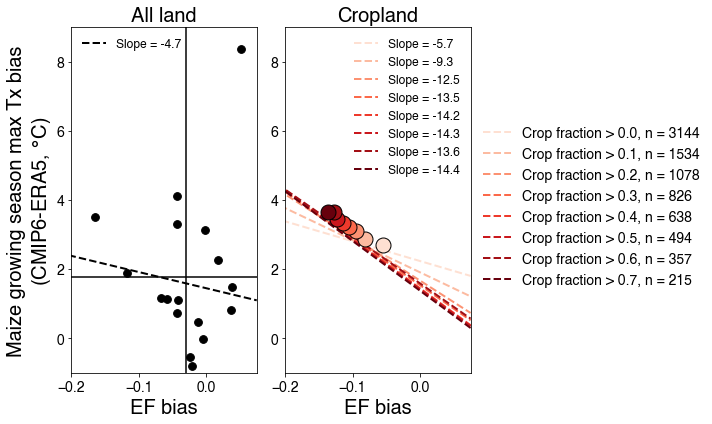

In [256]:

x1 = -.25
x2 = .075
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].set_xlim([-.2, .075])
ax[0].set_ylim([-1, 9])


nn_cropland = np.where((crop_all_area_regrid_1d >= 0))[0]

tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                  yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()


ax[0].plot([np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(ef_mean_bias_global_crop_1d)], [-1,9], '-k')
ax[0].plot([x1, x2], [np.nanmean(tasmax_max_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d)], '-k')
ax[0].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color='k', label='Slope = %.1f'%mdl.params[1])
ax[0].scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60, color='k')
ax[0].set_xlabel('EF bias', fontsize=20)
ax[0].set_ylabel('Maize growing season max Tx bias\n(CMIP6-ERA5, $\degree$C)', fontsize=20)
ax[0].set_title('All land', fontsize=20)
ax[0].legend(frameon=False, prop={'size': 12})

ax[1].set_xlim([-.2, .075])
ax[1].set_ylim([-1, 9])

cmap = plt.get_cmap('Reds')
lims = np.arange(0, .71, .1)#[0, .01, .05, .1, .15, .25, .4]

leg2_label = []
leg1_label = []

for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]
    
    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                      yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
    ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)

    nn = np.where(~np.isnan(tasmax_max_bias_global_crop_1d) & ~np.isnan(ef_mean_bias_global_crop_1d))[0]
    X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
    mdl = sm.RLM(tasmax_max_bias_global_crop_1d[nn], X).fit()

    if i == 0:
        leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        leg1_label.append('Slope = %.1f'%(mdl.params[1]))
    else:
        leg2_label.append('Crop fraction > %.1f, n = %d'%(lim, len(nn_cropland)))
        leg1_label.append('Slope = %.1f'%(mdl.params[1]))
    
    ax[1].plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                        mdl.params[0]+x2*mdl.params[1]], '--', lw=2, color=cmap(((i+1)/len(lims))), label=label)
    
    

# ax[1].legend(loc='upper right', frameon=False)
# ax[1].plot([0, 0], [0,8], '-k')
leg1 = ax[1].legend(leg1_label, frameon=False, prop={'size': 12})
leg2 = ax[1].legend(leg2_label, frameon=False, bbox_to_anchor=(1.0, .75), prop={'size': 14})
ax[1].add_artist(leg1)
ax[1].set_title('Cropland', fontsize=20)

# now draw markers for ef/bias averages
for i, lim in enumerate(lims):
    nn_cropland = np.where((crop_all_area_regrid_1d > lim))[0]

    tasmax_max_bias_global_crop_1d = yearly_tasmax_grow_max_bias.reshape([yearly_tasmax_grow_max_bias.shape[0], yearly_tasmax_grow_max_bias.shape[1], \
                                                                      yearly_tasmax_grow_max_bias.shape[2]*yearly_tasmax_grow_max_bias.shape[3]])
    tasmax_max_bias_global_crop_1d = np.nanmean(np.nanmean(tasmax_max_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                      yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
    ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
    ax[1].plot(np.nanmean(ef_mean_bias_global_crop_1d), np.nanmean(tasmax_max_bias_global_crop_1d), 'o', markersize=15, markeredgecolor='k', color=cmap(((i+1)/len(lims))))

# plt.scatter(ef_mean_bias_global_crop_1d, tasmax_max_bias_global_crop_1d, s=60)
plt.xlabel('EF bias', fontsize=20)
# plt.ylabel('Maize growing season max Tx bias (CMIP6-ERA5, $\degree$C)')
# plt.title('Global cropland (varied fractions)')

plt.tight_layout()
plt.savefig('ef-bias-model-comparison.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0.5, 1.0, 'Global cropland (fraction > 0.25)')

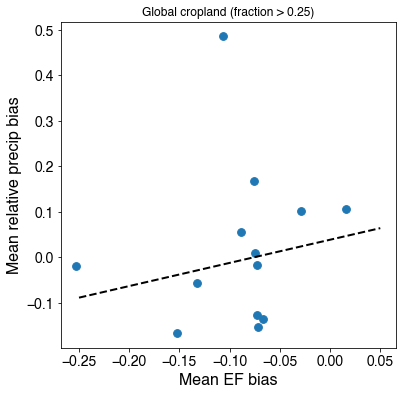

In [257]:

nn_cropland = np.where((crop_all_area_regrid_1d>.25))[0]

pr_grow_rel_bias_global_crop_1d = yearly_pr_grow_bias_rel.reshape([yearly_pr_grow_bias_rel.shape[0], yearly_pr_grow_bias_rel.shape[1], \
                                                                  yearly_pr_grow_bias_rel.shape[2]*yearly_pr_grow_bias_rel.shape[3]])
pr_grow_rel_bias_global_crop_1d = np.nanmean(np.nanmean(pr_grow_rel_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)
pr_grow_rel_bias_global_crop_1d[pr_grow_rel_bias_global_crop_1d>2] = np.nan
ef_mean_bias_global_crop_1d = yearly_ef_grow_bias.reshape([yearly_ef_grow_bias.shape[0], yearly_ef_grow_bias.shape[1], \
                                                                  yearly_ef_grow_bias.shape[2]*yearly_ef_grow_bias.shape[3]])
ef_mean_bias_global_crop_1d = np.nanmean(np.nanmean(ef_mean_bias_global_crop_1d[:, :, nn_cropland], axis=2), axis=1)


nn = np.where(~np.isnan(ef_mean_bias_global_crop_1d) & ~np.isnan(pr_grow_rel_bias_global_crop_1d))[0]
X = sm.add_constant(ef_mean_bias_global_crop_1d[nn])
mdl = sm.RLM(pr_grow_rel_bias_global_crop_1d[nn], X).fit()

x1 = -.25
x2 = .05
plt.figure(figsize=(6,6))

# plt.plot([np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], [0,8], '-k')
# plt.plot([x1, x2], [np.nanmean(pr_grow_rel_bias_global_crop_1d), np.nanmean(pr_grow_rel_bias_global_crop_1d)], '-k')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], \
                    mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.scatter(ef_mean_bias_global_crop_1d, pr_grow_rel_bias_global_crop_1d, s=60)
plt.xlabel('Mean EF bias')
plt.ylabel('Mean relative precip bias')
plt.title('Global cropland (fraction > 0.25)')


Text(0, 0.5, 'Density')

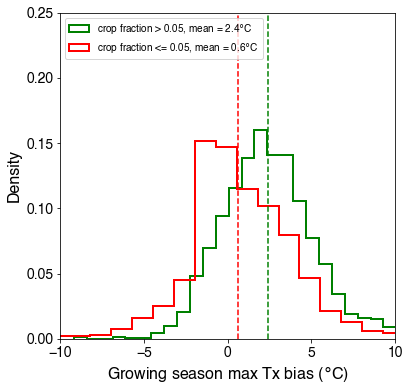

In [258]:
nn_tasmax_grow_max_crop = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_all_area_regrid_1d>.05) & (crop_all_area_regrid_1d<=1))[0]
nn_tasmax_grow_max_nocrop = np.where((~np.isnan(crop_all_area_regrid_1d)) & (~np.isnan(yearly_tasmax_grow_max_bias_mean_1d)) & (crop_all_area_regrid_1d <=.05))[0]

plt.figure(figsize=(6,6))
plt.xlim([-10,10])
plt.ylim([0, .25])
histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop], bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='crop fraction > 0.05, mean = %0.1f$\degree$C'%np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop]))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop], bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='crop fraction <= 0.05, mean = %0.1f$\degree$C'%np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop]))

plt.plot([np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop]), np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_nocrop])], [0, .25], '--r')
plt.plot([np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop]), np.nanmean(yearly_tasmax_grow_max_bias_mean_1d[nn_tasmax_grow_max_crop])], [0, .25], '--g')
plt.legend()
plt.xlabel('Growing season max Tx bias ($\degree$C)')
plt.ylabel('Density')